In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from utils import get_mean_normal, find_location_index_cell_type, metrics_vector, discrete_histogram
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import anndata

In [3]:
from scvi.model import DestVI

In [4]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [5]:
sns.reset_orig()
sc.settings._vector_friendly = True
# p9.theme_set(p9.theme_classic)
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (4, 4)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

plt.rcParams["font.size"] = 11
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams['font.weight'] = 500

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['xtick.minor.size'] = 1.375
plt.rcParams['xtick.major.size'] = 2.75
plt.rcParams['xtick.major.pad'] = 2
plt.rcParams['xtick.minor.pad'] = 2

plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['ytick.minor.size'] = 1.375
plt.rcParams['ytick.major.size'] = 2.75
plt.rcParams['ytick.major.pad'] = 2
plt.rcParams['ytick.minor.pad'] = 2

plt.rcParams["legend.fontsize"] = 12
plt.rcParams['legend.handlelength'] = 1.4
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.scatterpoints'] = 3
plt.rcParams['legend.frameon'] = False

plt.rcParams['lines.linewidth'] = 1.7

DPI = 300

In [6]:
path = "/home/ubuntu/simu_runs/run_B"

sc_adata = sc.read_h5ad(path+"/sc_simu.h5ad")
st_adata = sc.read_h5ad(path+"/st_simu.h5ad")

In [12]:
# learn one model per cell type
rf_model = {}
# SVC has convergence issues; sticking to RF
# svc_model = {}
for ct in range(5):
    indices = np.where(sc_adata.obs["cell_type"] == ct)[0]
    x_train = sc_adata.X[indices]
    y_train = sc_adata.obs["8th_sub-cell_type"][indices] - 8 * ct
    rf_model[ct] = RandomForestClassifier(n_jobs=4).fit(x_train, y_train)
#     svc_model[ct] = LinearSVC().fit(x_train, y_train)

In [13]:
def hash_loc(loc):
    if len(loc.shape) == 1:
        return loc[0] * loc[1] * 4
    else:
        return loc[:, 0] * loc[:, 1] * 4

In [14]:
spatial_model = DestVI.load(path+"/destvi_latent", st_adata)

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'ind_x']                                                                            
INFO     Successfully registered anndata object containing 1600 cells, 2000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


In [30]:
threshold_gt = 0.4
spot_selection = np.where(st_adata.obsm["cell_type"].max(1) > threshold_gt)[0]
s_location = st_adata.obsm["locations"][spot_selection]
s_ct = st_adata.obsm["cell_type"][spot_selection, :].argmax(1)
s_gamma = st_adata.obsm["gamma"][spot_selection]
# order the locations in the single-cell to recover the mapping ST <-> scRNA
_, rank = np.unique(sc_adata.obsm["locations"], return_inverse=True, axis=0)

res = []
for ct in range(5):
    # for a given cell type, select spots with high density
    indices, _ = find_location_index_cell_type(st_adata.obsm["locations"], ct, 
                                        s_location, s_ct)
    y_true = []
    for i in indices:
        sc_i = np.where(rank == i)[0]
        items = range(ct*8, (ct + 1)*8)
        y_true += [sc_adata.obs["8th_sub-cell_type"][sc_i].value_counts().filter(items).idxmax()]
    y_true = np.array(y_true) - 8 * ct
    y_pred = rf_model[ct].predict(st_adata.X[indices])
#         print(sc_adata.obs["cell_type"][sc_i].value_counts())
    
    # TODO: Import the DestVI model and compare those estimates
    expression = spatial_model.get_scale_for_ct(spatial_model.cell_type_mapping[ct], indices=indices).values
    normalized_expression = expression / np.sum(expression, axis=1)[:, np.newaxis]
    lib = sc_adata.obs["n_counts"][sc_adata.obs["cell_type"] == ct].mean()
    y_pred_vi = rf_model[ct].predict(lib*normalized_expression)
    
    res += [[accuracy_score(y_true, y_pred), accuracy_score(y_true, y_pred_vi)]]

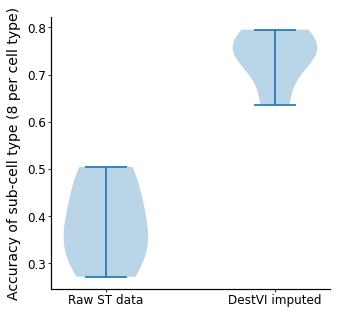

In [32]:
plt.figure(figsize=(5, 5))
plt.violinplot(np.array(res))
plt.ylabel("Accuracy of sub-cell type (8 per cell type)")
plt.xticks(ticks=[1, 2], labels=["Raw ST data", "DestVI imputed"])
plt.show()